# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

In [2]:
import torch
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.device_count()
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

## Please install the Pytorch library on your computer before you run this notebook.

The installation instructions can be found here. (https://pytorch.org/get-started/locally/)

In this exercise, we will use the Pytorch library (https://pytorch.org/) to build and train our deep neural networks. In the deep learning literature, especially in the research community, Pytorch is SUPER popular due to its automatic differentiation and dynamic computational graph (i.e., the graph is automatically generated, which is different from tensorflow where you have to define them beforehand). Briefly spearking, using Pytorch, you only have to build your neural network, define the forward pass, and the loss function. The library will automatically compute the weights and perform the backpropagation for you. For more details about Pytorch, we recommend you check the tutorails on the offical website to learn the basics (https://pytorch.org/tutorials/). 

Please try to learn the basics as much as you can. If you have any questions, feel free to ask them on Piazza or TA hours. 

In [46]:
import numpy as np
import tqdm
import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
from gym import spaces
import gym

import base64, io

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [2]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Episodes")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

# Q3 : Implement the REINFORCE algorithm on page 328

Here, we will implement the REINFORCE algorithm on page 328 using the neural networks. 

Same as the ex8, we still use the Pytorch library to build the neural networks and train them.

Please read the pseudocode on page 328 carefully and complete the implementation below.

## Model the policy using a fully connected neural network

Here, you are asked to implement a neural network to approximate the stochastic policy \pi(a|s). In particular, the architecture of the neural network is as follows:

Layer 1: Linear, input size 3, output size 128

Activation 1: relu

Layer 2: Linear, input size 128, output size 4

Activation 2: softmax

Note that, instead of using the original state = [x, y], we represent each state as [x / 10, y / 10, 1]. In other words, we use a simple normalized feature.  

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [39]:
class PolicyNet(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(PolicyNet, self).__init__()

        """ CODE HERE:
                Implement the neural network here
        """
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        """ CODE HERE:
                Implement the forward propagation
        """
        x = F.relu(self.fc1(x))
        y = F.softmax(self.fc2(x))
        return y
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

## Implement the REINFORCE agent as a class

We implement the REINFORCE agent as a class. Specifically, we model the policy as a fully connected neural networks. 

Besides, we implement a function to derive an action from the neural network

## Implement the REINFORCE algorithm as a class

In [40]:
def rolling_average(data, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [123]:
class REINFORCEAgentTrainer(object):
    def __init__(self, policy, env, params):
        # Agent object
        self.policy = policy
        
        # Environment object
        self.env = env
        
        # Training parameters
        self.params = params

        # Lists to store the log probabilities and rewards for one episode
        self.saved_log_probs = []
        self.saved_rewards = []

        # Gamma
        self.gamma = params['gamma']
        
        # Small value for returns normalization
        self.eps = params['epsilon']

        # Create the optimizer
        """ CODE HERE:
                Implement the Adam optimizer with the learning rate in params
        """
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=params['learning_rate'])

    def update_agent_policy_network(self):
        # We define a list to store the policy loss for each time step
        policy_loss = []
        
        # We define a special list to store the return for each time step
        returns = deque()

        """ CODE HERE:
                Compute the return for each time step
                
                Hint: We usually compute the return from the end. Remember to append it 
                      correctly. You can use "returns.appendleft(G)"
        """
        # compute returns for every time step
        G = 0
        for r in self.saved_rewards[::-1]:
            G = r + self.gamma*G
            returns.appendleft(G)
        # normalize the returns: for stablize the training
        returns = torch.tensor(returns)
        norm_returns = (returns - returns.mean()) / (returns.std() + self.eps)

        """ CODE HERE:
                Now, we have the return for each time step and log probability for each time step.
                Then, we can compute the loss for each time step using the equation of updating \theta
                in the pseudocode. 
        """
        for log_prob, r in zip(self.saved_log_probs, norm_returns):
            # compute the loss for each time step
            policy_loss.append(-log_prob * r)
        # We sum all the policy loss
        policy_loss = torch.cat(policy_loss).sum()
        
        """ CODE HERE:
                Implement the one-step backpropagation
        """
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        # after the backpropagation, clear the data to get ready to store the new episode data.
        del self.saved_log_probs[:]
        del self.saved_rewards[:]

        return returns[0].item(), policy_loss.item()

    def rollout(self):
        """ Function to collect one episode from the environment
        """
        """ CODE HERE:
                Implement the code to collect one episode. 
                
                Specifically, we only collect the rewards and corresponding log probability, which
                should be stored in "self.saved_rewards" and "self.saved_log_probs", respectively. 
                
                This is because we only need the return_t and log_probability to update the weights
                of the policy.
      
        """
        # reset the env
        state = self.env.reset()
        done = False
        # start rollout
        while not done:
            # render the action and log probability given a state (use the feature of the state)
            action, log_prob = self.policy.act(state)
            # save the log probability to "self.saved_log_probs"
            self.saved_log_probs.append(log_prob)
            # render the next state, reward
            next_state, reward, done, _ = self.env.step(action)
            # save the reward to "self.saved_rewards"
            self.saved_rewards.append(reward)
            # check termination
            if done:
                break;
            else:
                state = next_state
                
    def run_train(self):
        # number of the training epsiode
        episode_num = self.params['episode_num']
        
        # list to store the returns and losses during the training
        train_returns = []
        train_losses = []
        
        # start the training
        ep_bar = tqdm.trange(episode_num)
        for ep in ep_bar:
            """CODE HERE
                    Implement the REINFORCE algorithm here.
            """
            # collect one episode
            self.rollout()
            # update the policy using the collected episode
            G, loss = self.update_agent_policy_network()
            # save the returns and losses
            train_returns.append(G)
            train_losses.append(loss)
            
            # add description
            ep_bar.set_description(f"Episode={ep} | Discounted returns = {G} | loss = {loss:.2f}")
            
        # we have to smooth the returns for plotting
        smoothed_returns = rolling_average(np.array(train_returns), window_size=100)
        smoothed_losses = rolling_average(np.array(train_losses), window_size=100)
        
        return smoothed_returns, smoothed_losses

## Main function to run the training

In [124]:
if __name__ == "__main__":
    my_env = gym.make('CartPole-v1')

    train_params = {
        'episode_num': 6000,
        'learning_rate': 1e-4,
        'gamma': 1.0,
        'epsilon': 1e-6,

        'action_num': my_env.action_space.n,
        'hidden_dim': 128
        'observation_dim': 4
    }

    results_1_returns = []
    results_1_losses = []
    for _ in range(1):
        policy = PolicyNet(train_params['observation_dim'],
                           train_params['hidden_dim'],
                           train_params['action_num']).to(device)

        my_trainer = REINFORCEAgentTrainer(policy, my_env, train_params)
        returns, losses = my_trainer.run_train()
        
        results_1_returns.append(returns)
        results_1_losses.append(losses)

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]C:\Users\GHOSH\AppData\Local\Temp\ipykernel_34428\1689890139.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.fc2(x))
Episode=5999 | Discounted returns = 310.0 | loss = 3.01: 100%|█████████████████████| 6000/6000 [20:41<00:00,  4.83it/s]


In [125]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(policy, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    G = 0
    for t in range(20000):
        vid.capture_frame()
        action, _ = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        G += reward
        state = next_state
        if done:
            break
    print(G)
    vid.close()
    env.close()

In [126]:
show_video_of_model(policy, 'CartPole-v1')

C:\Users\GHOSH\AppData\Local\Temp\ipykernel_34428\1689890139.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.fc2(x))


500.0


In [127]:
show_video('CartPole-v1')

# Plot the learning curves: discounted returns w.r.t epsiodes

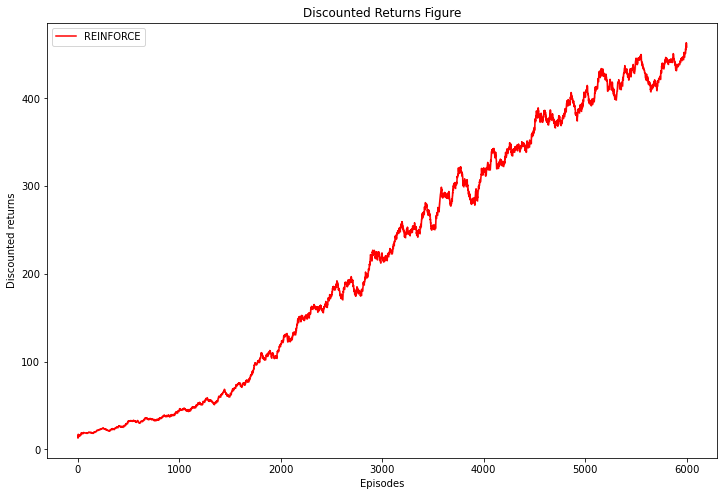

In [128]:
plot_curves([np.array(results_1_returns)],
            ['REINFORCE'],
            ['r'],
            'Discounted returns',
            "Discounted Returns Figure")

# Plot the loss curves: loss w.r.t epsiodes

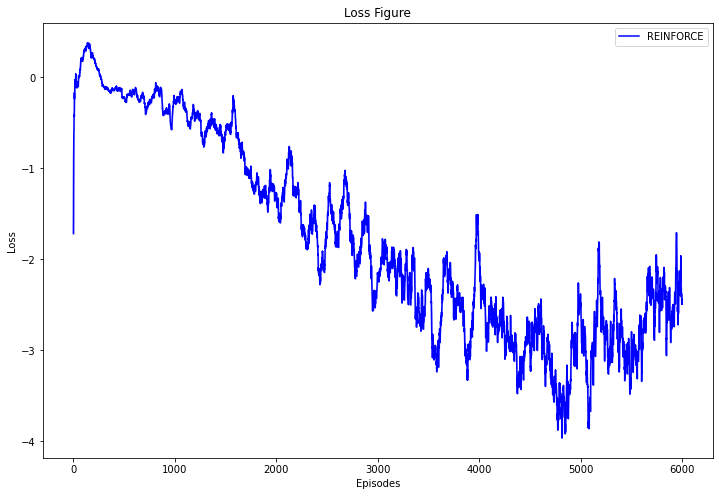

In [129]:
plot_curves([np.array(results_1_losses)], ['REINFORCE'], ['b'], 'Loss', "Loss Figure")

# Q3 : Implement the REINFORCE algorithm with baseline on page 330

Here, we will implement the REINFORCE algorithm with baseline on page 330 using the neural networks. 

Same as the ex8, we still use the Pytorch library to build the neural networks and train them.

Please read the pseudocode on page 330 carefully and complete the implementation below.

In [145]:
class REINFORCEBaselineNet(nn.Module):
    def __init__(self, input_dims, hidden_dims, action_space):
        super(REINFORCEBaselineNet, self).__init__()

        """ CODE HERE:
                Implement the critic network here. The architecture should be as follows:
                
                Layer 1: Linear, input size 3, output size 128

                Activation 1: relu

                Layer 2: Linear, input size 128, output size 1

                Activation 2: identity
        """
        # critic network
        self.fc1_critic = nn.Linear(input_dims,hidden_dims)
        self.fc2_critic = nn.Linear(hidden_dims,1)

        # actor network
        self.fc1_actor = nn.Linear(input_dims,hidden_dims)
        self.fc2_actor = nn.Linear(hidden_dims,action_space)

    def forward(self, x):
        # compute the critic
        critic_x = F.relu(self.fc1_critic(x))
        state_value = self.fc2_critic(critic_x)

        # compute the actor
        actor_x = F.relu(self.fc1_actor(x))
        action_probs = F.softmax(self.fc2_actor(actor_x), dim=1)

        return state_value.cpu(), action_probs.cpu()
    
    def act(self, state):
        # derive an action, log probability, and the state value
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        state_value, action_probs = self.forward(state)
        m = Categorical(action_probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob, state_value

In [146]:
class REINFORCEBaselineAgentTrainer(object):
    def __init__(self, policy, env, params):
        # Agent object
        self.policy = policy
        
        # Environment object
        self.env = env
        
        # Training parameters
        self.params = params

        # Lists to store the log probabilities, state values, and rewards for one episode
        self.saved_log_probs = []
        self.saved_state_values = []
        self.saved_rewards = []

        # Gamma
        self.gamma = params['gamma']

        # Small value for returns normalization
        self.eps = params['epsilon']

        # Create the optimizer
        """ CODE HERE:
                Implement the Adam optimizer with the learning rate in params
        """
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=params['learning_rate'])
        self.loss_func = nn.MSELoss()
        

    def update_agent_policy_network(self):
        # We define a list to store the policy loss for each time step
        policy_loss = []
        
        # We define a list to store the state value for each time step
        value_loss = []
        
        # We define a list to store the return for each time step
        returns = deque()

        """ CODE HERE:
                Compute the return for each time step
                
                Hint: We usually compute the return from the end. Remember to append it 
                      correctly. You can use "returns.appendleft(G)"
        """
        # compute returns for every time step
        G = 0
        for r in self.saved_rewards[::-1]:
            G = r + self.gamma*G
            returns.appendleft(G)
        # normalize the returns
        returns = torch.tensor(returns)
        norm_returns = (returns - returns.mean()) / (returns.std() + self.eps)
        

        """ CODE HERE:
                Now, we have the return, state value, and log probability for each time step.
                Then, we can compute the loss for each time step using the equation of updating \theta
                in the pseudocode. 
        """
        for log_prob, val, r in zip(self.saved_log_probs, self.saved_state_values, norm_returns):
            # compute the policy loss for each time step
            pol_loss = -log_prob * (r - val.detach())
            val_loss = self.loss_func(val, r)
            policy_loss.append(pol_loss)
            value_loss.append(val_loss)
        # compute the total loss
        total_loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()

        # optimization
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        del self.saved_log_probs[:]
        del self.saved_state_values[:]
        del self.saved_rewards[:]

        return returns[0].item(), total_loss.item()

    def rollout(self):
        """ CODE HERE:
                Implement the code to collect one episode. 
                
                Specifically, we only collect the rewards and corresponding log probability, which
                should be stored in "self.saved_rewards" and "self.saved_log_probs", respectively. 
                
                This is because we only need the return_t and log_probability to update the weights
                of the policy.
      
        """
        # reset the env
        state = self.env.reset()
        done = False
        # start rollout
        while not done:
            # render the action and log probability given a state (use the feature of the state)
            action, log_prob, state_value = self.policy.act(state)
            # save the log probability to "self.saved_log_probs"
            self.saved_log_probs.append(log_prob)
            # save the state value to "self.saved_state_values"
            self.saved_state_values.append(state_value)
            # render the next state, reward
            next_state, reward, done, _ = self.env.step(action)
            # save the reward to "self.saved_rewards"
            self.saved_rewards.append(reward)
            # check termination
            if done:
                break;
            else:
                state = next_state

    def run_train(self):
        # number of the training epsiode
        episode_num = self.params['episode_num']
        
        # list to store the returns and losses during the training
        train_returns = []
        train_losses = []
        
        ep_bar = tqdm.trange(episode_num)
        for ep in ep_bar:  
            """CODE HERE
                    Implement the REINFORCE algorithm here.
            """
            # collect one episode
            self.rollout()
            # update the policy using the collected episode
            G, loss = self.update_agent_policy_network()
            # save the returns and losses
            train_returns.append(G)
            train_losses.append(loss)
            
            # save the returns and losses
            train_returns.append(G)
            train_losses.append(loss)

            ep_bar.set_description(f"Episode={ep} | Discounted returns = {G} | loss = {loss:.2f}")
            
        # we have to smooth the returns for plotting
        smoothed_returns = rolling_average(np.array(train_returns), window_size=100)
        smoothed_losses = rolling_average(np.array(train_losses), window_size=100)
        
        return smoothed_returns, smoothed_losses

In [147]:
if __name__ == "__main__":
    my_env = gym.make('CartPole-v1')

    train_params = {
        'episode_num': 6000,
        'learning_rate': 1e-4,
        'gamma': 1.0,
        'epsilon': 1e-6,

        'action_num': my_env.action_space.n,
        'observation_dim': 4,
        'hidden_dim': 128
    }
    
    results_2_returns = []
    results_2_losses = []
    for _ in range(2):
        policy = REINFORCEBaselineNet(train_params['observation_dim'],
                                      train_params['hidden_dim'],
                                      train_params['action_num']).to(device)
        my_trainer = REINFORCEBaselineAgentTrainer(policy, my_env, train_params)
        returns, losses = my_trainer.run_train()
        
        results_2_returns.append(returns)
        results_2_losses.append(losses)

Episode=5999 | Discounted returns = 500.0 | loss = 396.44: 100%|███████████████████| 6000/6000 [30:50<00:00,  3.24it/s]
Episode=5999 | Discounted returns = 500.0 | loss = 271.78: 100%|███████████████████| 6000/6000 [33:30<00:00,  2.98it/s]


# Plot the learning curves: discounted returns w.r.t epsiodes

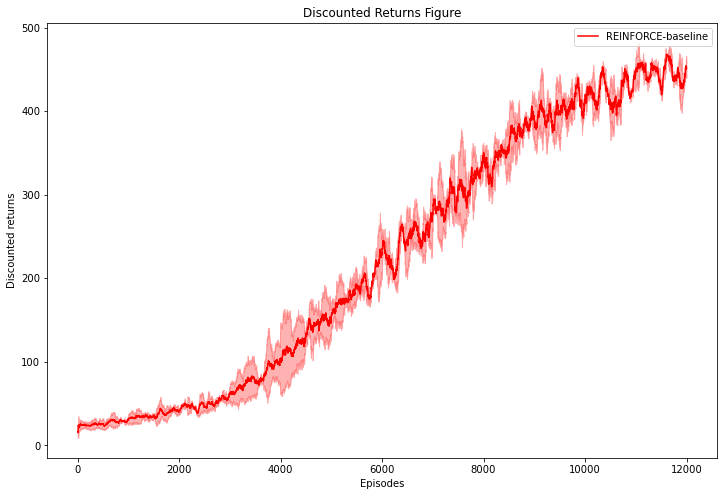

In [148]:
plot_curves([np.array(results_2_returns)], ['REINFORCE-baseline'], ['r'], 'Discounted returns', "Discounted Returns Figure")

# Plot the loss curves: loss w.r.t epsiodes

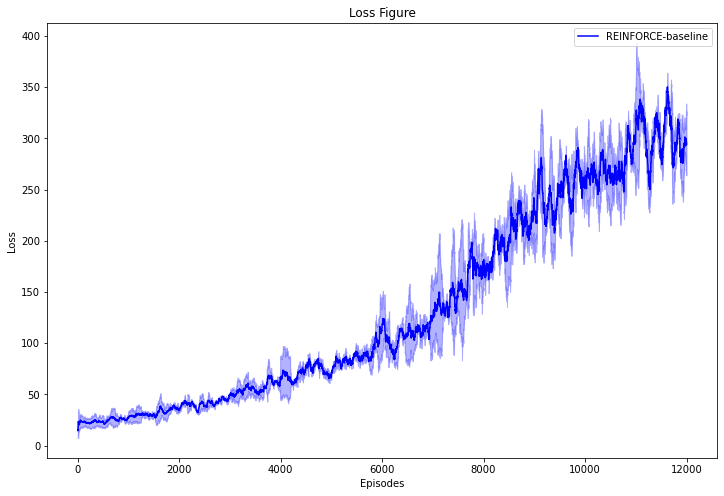

In [149]:
plot_curves([np.array(results_2_losses)], ['REINFORCE-baseline'], ['b'], 'Loss', "Loss Figure")

# Q3 - Compare vanilla REINFORCE algorithm v.s. REINFORCE with baseline.

# Compare learning curves : discounted returns w.r.t epsiodes

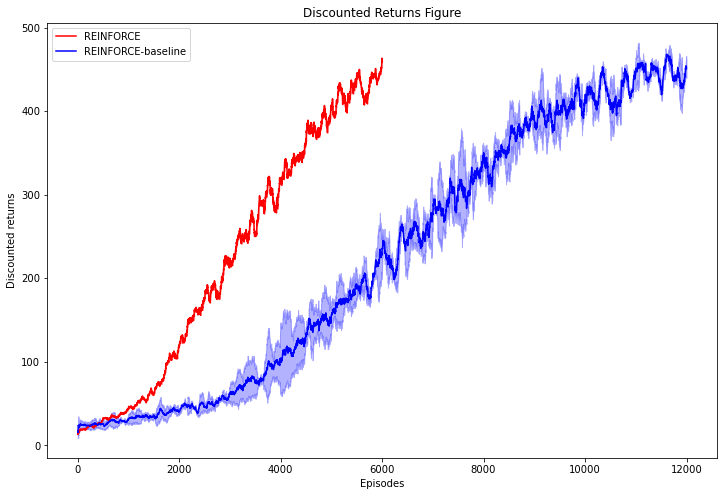

In [150]:
plot_curves([np.array(results_1_returns), np.array(results_2_returns)], 
            ['REINFORCE', 'REINFORCE-baseline'], 
            ['r', 'b'], 'Discounted returns', "Discounted Returns Figure")

# Compare loss curves : loss w.r.t epsiodes

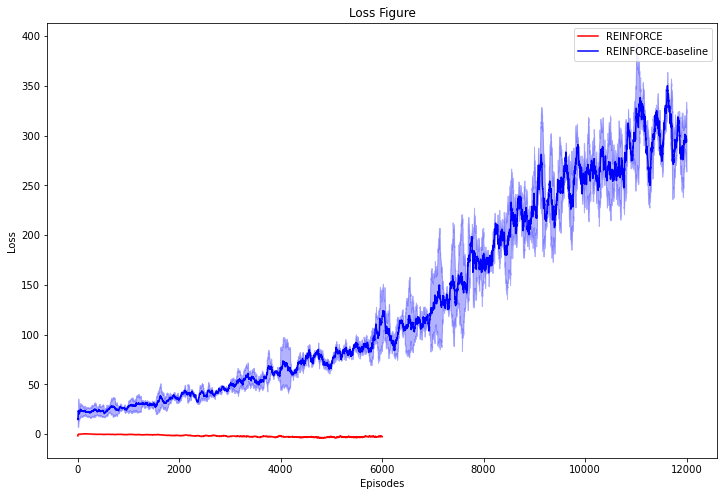

In [151]:
plot_curves([np.array(results_1_losses), np.array(results_2_losses)], 
            ['REINFORCE', 'REINFORCE-baseline'], 
            ['r', 'b'], 'Loss', "Loss Figure")

In [154]:
def show_video_of_model(policy, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    G = 0
    for t in range(20000):
        vid.capture_frame()
        action, _, _ = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        G += reward
        state = next_state
        if done:
            break
    print(G)
    vid.close()
    env.close()

In [156]:
show_video_of_model(policy, 'CartPole-v1')

500.0


In [158]:
show_video('CartPole-v1')